In [1]:
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()



In [2]:
# Input data

# define a number of trees that should be used (default = 500)
est = 500

# the remote sensing image you want to classify
img_RS = 'N:\\Projekt_Wetscapes\\Bearbeitung\\2019_08_12_Lichtehagen_Biomass\\Results\\stack_all_data_tif.tif'


# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'N:\\Projekt_Wetscapes\\Bearbeitung\\2019_08_12_Lichtehagen_Biomass\\Results\\biomasse.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM'


# directory, where the result should be saved:
prediction_map = 'N:\\Projekt_Wetscapes\\Bearbeitung\\2019_08_12_Lichtehagen_Biomass\\Results\\prediction_map.tif'


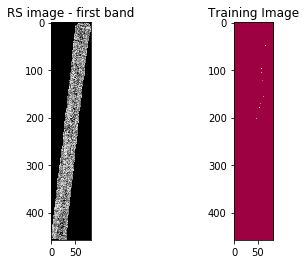

In [3]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()


# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()



# In[19]:


# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [4]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))

We have 25 training samples


In [5]:
# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]


In [6]:
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (25, 19)
Our y array is sized: (25,)


In [7]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=500,
                             n_jobs=-1, # using all cores
                             oob_score=True,
                             random_state=0,
                             verbose=0,
                             warm_start=False)
RFR.fit(X,y)
RFR.score(X,y)

0.9088030031997921

In [16]:
# save the regression model to disk!
from joblib import dump, load

save_model = 'N:\\Projekt_Wetscapes\\Bearbeitung\\2019_08_12_Lichtehagen_Biomass\\Results\\RFR.joblib'

dump(RFR, save_model)

# load model:
#RFR_loaded = load(save_model)

['N:\\Projekt_Wetscapes\\Bearbeitung\\2019_08_12_Lichtehagen_Biomass\\Results\\RFR.joblib']

In [8]:
#print(RFR.estimators_)
#print(RFR.feature_importances_)
#print(RFR.n_features_)
#print(RFR.n_outputs_)
#print(RFR.oob_score_)
print(RFR.oob_prediction_)

[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]


[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]
[160.0, 150.0, 70.0, 180.0, 270.0, 380.0, 250.0, 320.0, 790.0, 270.0, 510.0, 230.0, 140.0, 140.0, 180.0, 160.0, 150.0, 190.0, 130.0, 170.0, 330.0, 420.0, 380.0, 610.0, 250.0]


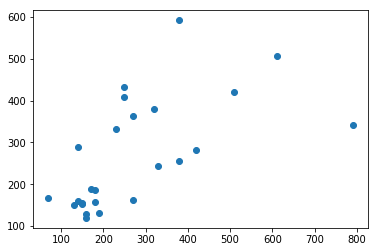

In [9]:
pred1 = np.array(RFR.oob_prediction_)
obs = np.array(y)
obs = [np.float(i) for i in obs]

print(pred1)
print(obs)
fig,ax = plt.subplots()
ax.scatter(obs,pred1)
plt.show()

In [10]:
print(RFR.feature_importances_)

[0.03076302 0.03309292 0.02191851 0.13730636 0.00691975 0.00954047
 0.01170407 0.06915878 0.16076827 0.00762218 0.00793526 0.0293753
 0.15360157 0.0169815  0.035099   0.0573158  0.04268409 0.14783471
 0.02037845]


In [11]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (458, 83, 19) to (38014, 19)


In [12]:
prediction_ = RFR.predict(img_as_array)

In [13]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (458, 83)


In [14]:
cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: N:\Projekt_Wetscapes\Bearbeitung\2019_08_12_Lichtehagen_Biomass\Results\prediction_map.tif


In [178]:
ABR = AdaBoostRegressor(base_estimator=None,
                       n_estimators=500,
                       learning_rate=1.0,
                       loss='linear',
                       random_state=None)

ABR.fit(X,y)
print(ABR.feature_importances_)
print('R² = {}'.format(ABR.score(X,y)))

[0.03715774 0.08543772 0.04735222 0.17732908 0.01075855 0.0096908
 0.01680421 0.03788069 0.07427071 0.00942609 0.01777424 0.06266764
 0.10019693 0.02159557 0.02792771 0.05154895 0.04930281 0.13961148
 0.02326686]
R² = 0.9912165722158924


In [195]:
SVR_ = svm.SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
SVR_.fit(X,y)
SVR_.score(X,y)

-0.06851969262785396

In [193]:
kr = KernelRidge(alpha=1,
                 kernel='linear',
                 gamma=None,
                 degree=3,
                 coef0=1,
                 kernel_params=None)

kr.fit(X,y)
kr.score(X,y)

0.7366296506204763

In [189]:
GPR = GaussianProcessRegressor(kernel=None,
                               alpha=1e-10,
                               optimizer='fmin_l_bfgs_b',
                               n_restarts_optimizer=0,
                               normalize_y=False,
                               copy_X_train=True,
                               random_state=None)
GPR.fit(X,y)
GPR.score(X,y)

1.0

In [ ]:

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
